In [ ]:
import numpy as np
import pandas as pd

from eval_utils import *
from model_evaluation import *

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('fraudTrain.csv')

## Препроцессинг

Повторим бейзлайн решение, обучив начальные модели 

In [2]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
df['day_of_month'] = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month

numerical_features = [
        'amt', 'lat', 'long', 'city_pop', 
        'merch_lat', 'merch_long', 'hour', 'day_of_week',
    ]

categorical_features = ['merchant', 'category', 'gender', 'job']


In [ ]:
X_train_proc, X_test_proc, y_train, y_test = get_baseline_preprocessing(df, numerical_features, categorical_features)
baseline_results = run_experiment(X_train_proc, X_test_proc, y_train, y_test, 
                                 "Бейзлайн")


ЭКСПЕРИМЕНТ: Бейзлайн
Train shape: (1037340, 1211), Test shape: (259335, 1211)


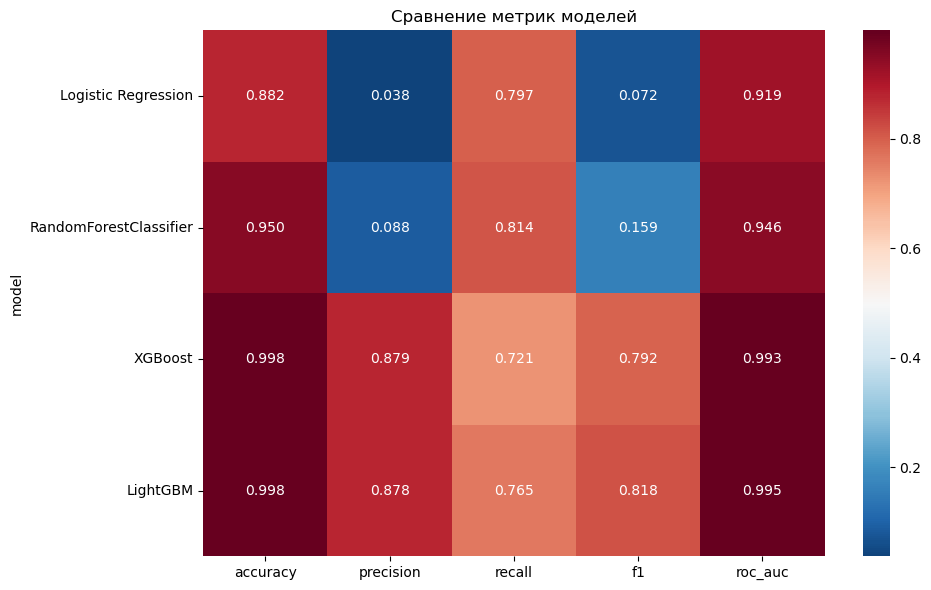

In [7]:
baseline_metrics = compare_models_metrics(baseline_results)

## Feature engineering

Будем использовать итеративный подход, Поочередно применять удачные преобразования, сравнивая результат каждого нового преобразования с результатом предыдущего

### Подход №1

- Сколько всего потратил клиент за день (daily_spending)

- Сколько транзакций было за день было у клиента по этой карте (daily_transactions)

In [ ]:
def calculate_daily_aggregates(df):
    """Добавляет ежедневные суммарные траты и количество транзакций по карте"""
    
    df['trans_date_only'] = df['trans_date_trans_time'].dt.date
    
    daily_agg = (
        df.groupby(['cc_num', 'trans_date_only'])
          .agg(daily_spending=('amt', 'sum'),
               daily_transactions=('amt', 'count'))
          .reset_index()
    )
    
    df = df.merge(daily_agg, on=['cc_num', 'trans_date_only'], how='left')
    
    return df.drop(columns='trans_date_only')


ЭКСПЕРИМЕНТ: Ежедневные траты и количество транзакций
Train shape: (1037340, 1213), Test shape: (259335, 1213)


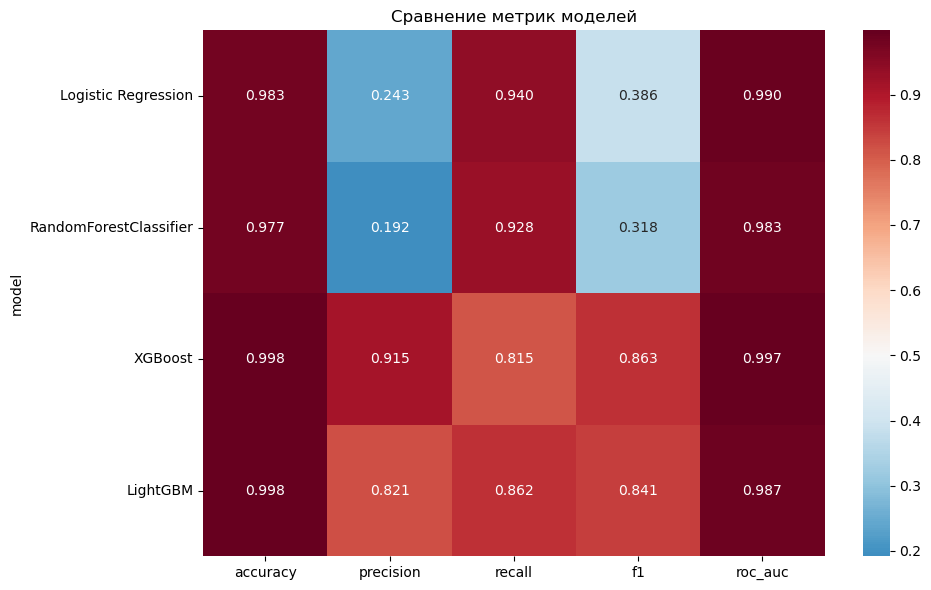

In [9]:
df_exp1 = calculate_daily_aggregates(df)

numerical_features = [
        'amt', 'lat', 'long', 'city_pop', 
        'merch_lat', 'merch_long', 'hour', 'day_of_week',
        'daily_spending', 'daily_transactions'
    ]

categorical_features = ['merchant', 'category', 'gender', 'job']

X_train_proc1, X_test_proc1, y_train_exp1, y_test_exp1 = get_baseline_preprocessing(df_exp1, numerical_features, categorical_features)
exp1_results = run_experiment(X_train_proc1, X_test_proc1, y_train_exp1, y_test_exp1,
                             "Ежедневные траты и количество транзакций")

# Сравнение с baseline
exp1_metrics = compare_models_metrics(exp1_results)

,accuracy,precision,recall,f1,roc_auc
model,,,,,
Logistic Regression,0.101178,0.205003,0.142572,0.313715,0.070806
RandomForestClassifier,0.026869,0.103871,0.113924,0.159165,0.036617
XGBoost,0.000686,0.036522,0.094604,0.070486,0.004101
LightGBM,0.000089,-0.057281,0.097268,0.023415,-0.008389


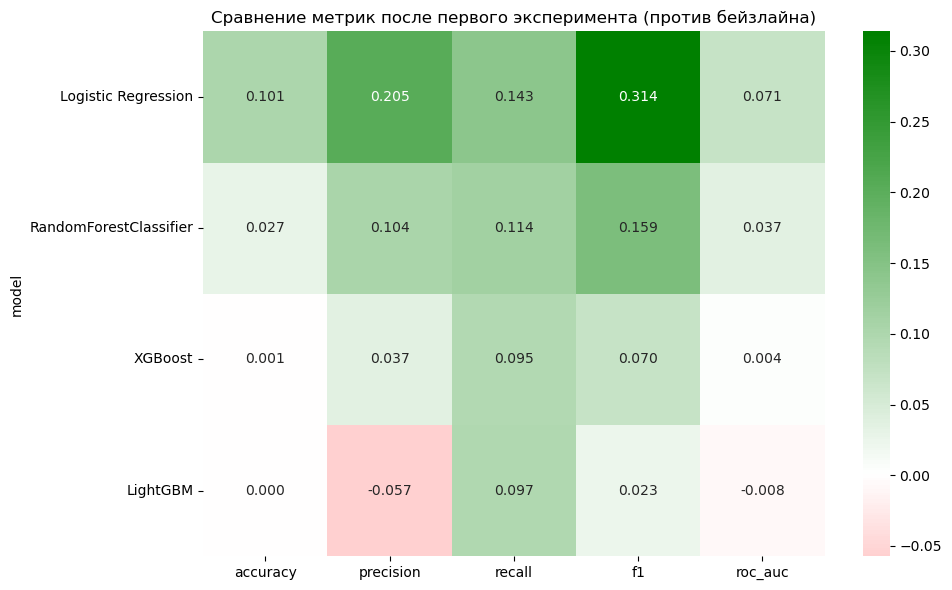

In [10]:
compare_after_add(exp1_metrics, baseline_metrics, 'Сравнение метрик после первого эксперимента (против бейзлайна)')

Получили заметные улучшения для Logistic Regression и RandomForestClassifier и незначительный прирост recall и f1 метрики для моделей бустинга

### Подход №2

Добавим признак, который вычисляет расстояние между между клиентом и продавцом. Таким образом, можно будет определить мошеннеческие транзакции, если между ними условно 5 минут и сотни километров.

In [ ]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """Вычисляет расстояние между объектами учитывая сферическую форму Земли (Haversine formula)"""
    R = 6371  # Earth radius in km
    
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    return R * c

def calculate_distance(df):
    df['distance'] = haversine_distance(
        df['lat'].values, 
        df['long'].values,
        df['merch_lat'].values, 
        df['merch_long'].values
    )
    return df


ЭКСПЕРИМЕНТ: Вычисление расстояния между клиентом и магазином
Train shape: (1037340, 1214), Test shape: (259335, 1214)


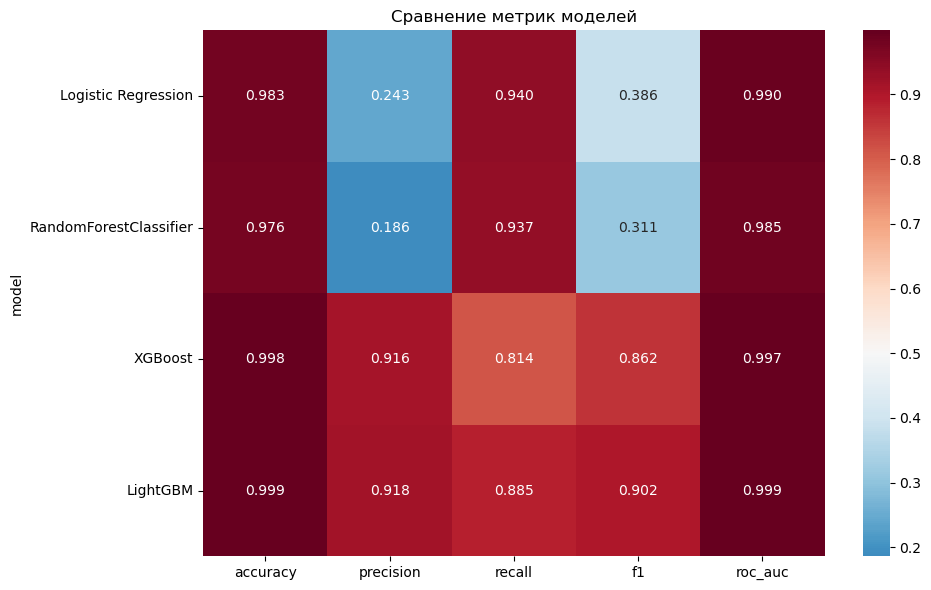

,accuracy,precision,recall,f1,roc_auc
model,,,,,
Logistic Regression,0.000015,0.000167,0.000000,0.000211,-0.000075
RandomForestClassifier,-0.001033,-0.005664,0.009327,-0.007301,0.002059
XGBoost,-0.000004,0.000560,-0.001332,-0.000498,-0.000041
LightGBM,0.000767,0.097386,0.023318,0.060549,0.012302


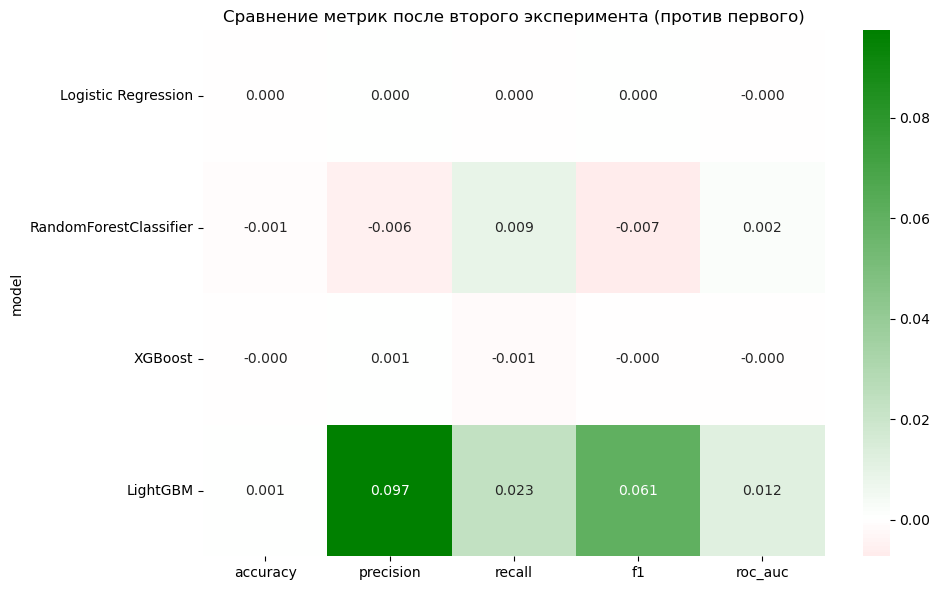

In [ ]:
df_exp2 = calculate_distance(df_exp1)

numerical_features = [
        'amt', 'lat', 'long', 'city_pop', 
        'merch_lat', 'merch_long', 'hour', 'day_of_week', 
        'daily_spending', 'daily_transactions', 'distance'
    ]

categorical_features = ['merchant', 'category', 'gender', 'job']

X_train_proc2, X_test_proc2, y_train_exp2, y_test_exp2 = get_baseline_preprocessing(df_exp2, numerical_features, categorical_features)
exp2_results = run_experiment(X_train_proc2, X_test_proc2, y_train_exp2, y_test_exp2,
                             "Вычисление расстояния между клиентом и магазином")


exp2_metrics = compare_models_metrics(exp2_results)

compare_after_add(exp2_metrics, exp1_metrics, 'Сравнение метрик после второго эксперимента (против первого)')

Немного улучшился бустинг LightGBM. Метрики остальных моделей не изменились

### Подход №3 

Вычислим возраст клиента на момент совершения транзакции (age). Таким образом можем вычислять нетипичных клиентов (в 18 лет совершать люксовые покупки и т.п.)

In [24]:
def calculate_age(df):
    """Вычисления возраста на основе даты рождения"""
    df['dob'] = pd.to_datetime(df['dob'])
    df['age'] = ((df['trans_date_trans_time'] - df['dob']).dt.days / 365.25).astype(int)
    return df


ЭКСПЕРИМЕНТ: Вычисление возраста клиента
Train shape: (1037340, 1215), Test shape: (259335, 1215)


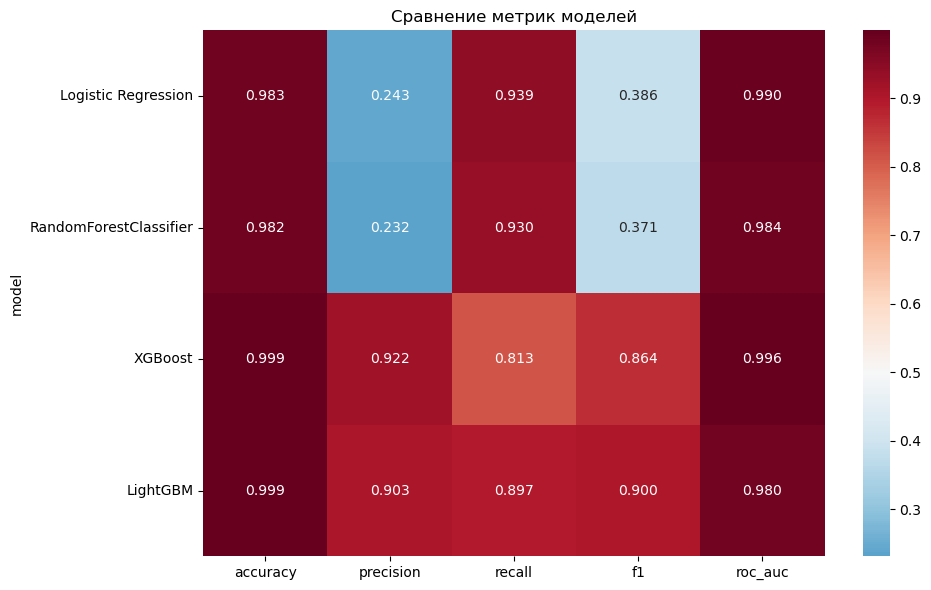

,accuracy,precision,recall,f1,roc_auc
model,,,,,
Logistic Regression,0.000031,0.000247,-0.000666,0.000255,-0.000134
RandomForestClassifier,0.005799,0.045299,-0.007328,0.060035,-0.000552
XGBoost,0.000031,0.006163,-0.000666,0.002344,-0.001062
LightGBM,-0.000035,-0.015096,0.011326,-0.001595,-0.018643


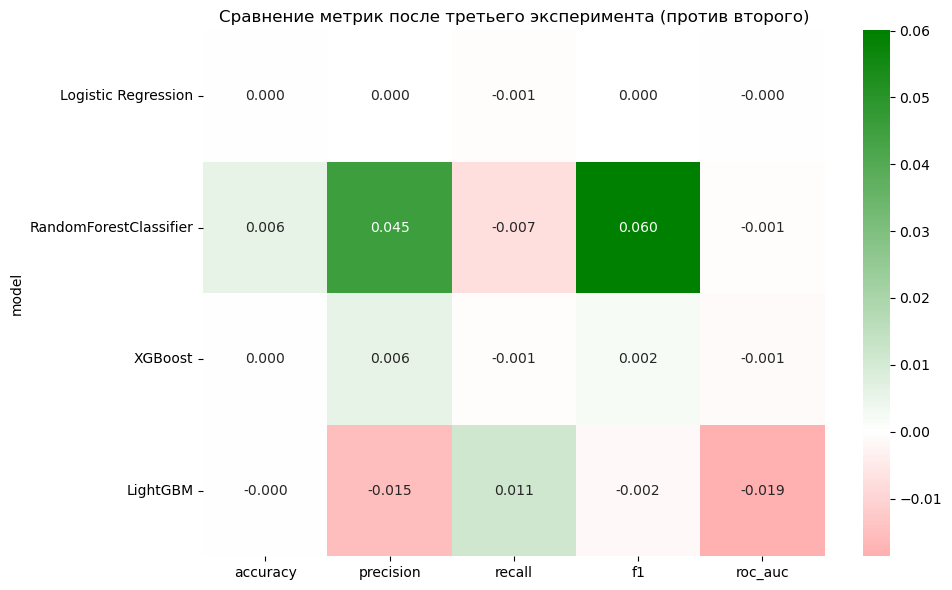

In [ ]:
df_exp3 = calculate_age(df_exp2)

numerical_features = [
        'amt', 'lat', 'long', 'city_pop', 
        'merch_lat', 'merch_long', 'hour', 'day_of_week', 
        'daily_spending', 'daily_transactions', 'distance','age'
    ]

categorical_features = ['merchant', 'category', 'gender', 'job']

X_train_proc3, X_test_proc3, y_train_exp3, y_test_exp3 = get_baseline_preprocessing(df_exp3, numerical_features, categorical_features)
exp3_results = run_experiment(X_train_proc3, X_test_proc3, y_train_exp3, y_test_exp3,
                                "Вычисление возраста клиента")

exp3_metrics = compare_models_metrics(exp3_results)
compare_after_add(exp3_metrics, exp2_metrics, 'Сравнение метрик после третьего эксперимента (против второго)')


Тут видим, незначительные улучшения precision и f1 метрики для RandomForestClassifier и recall для LightGBM

Итого после всех преобразований, метрики по сравнению с бейзлайном увеличелись следующим образом:

,accuracy,precision,recall,f1,roc_auc
model,,,,,
Logistic Regression,0.101224,0.205417,0.141905,0.314182,0.070597
RandomForestClassifier,0.031635,0.143507,0.115923,0.211899,0.038123
XGBoost,0.000713,0.043245,0.092605,0.072331,0.002998
LightGBM,0.000821,0.025008,0.131912,0.082370,-0.014730


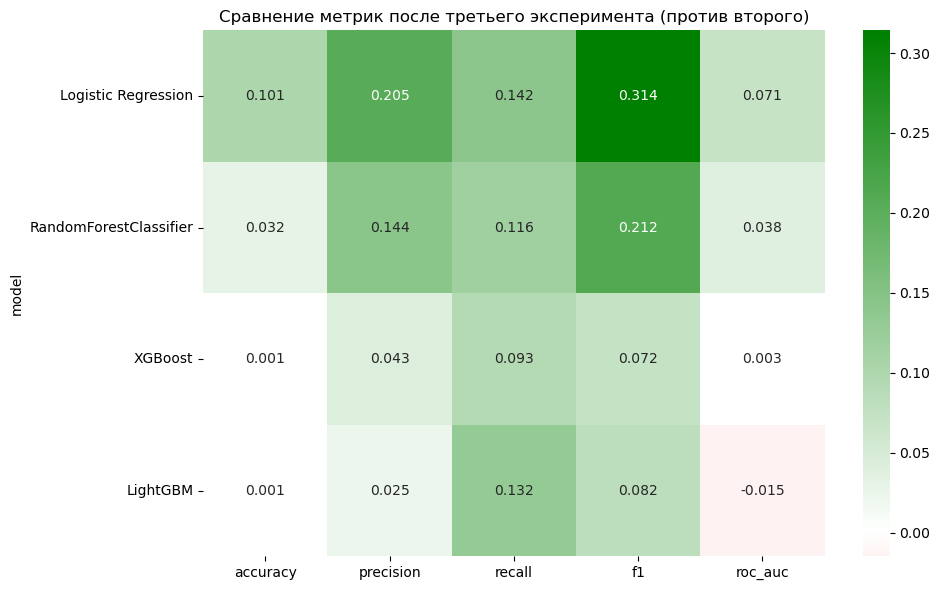

In [ ]:
compare_after_add(exp3_metrics, baseline_metrics, 'Сравнение метрик после третьего эксперимента (против бейзлайна)')

LightGBM изначально, на фоне остальных моделей среди бейзлайна была лидером. Теперь получилось увеличить ее recall на 0,132. Далее будем работать с этой моделью и попробуем улучшить ее качество с помощью подбора гиперпараметров

**Вывод**: таким образом, было проведено три эксперимента, в ходе которых добавлены 4 признака. Recall увеличился на 0.132, однако precision почти не изменился. Будем пробовать улучшить метрики путем подбора гиперпараметров.